In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kagglehub
import os
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
# Download the dataset
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

# Find the CSV file in the downloaded folder
for file in os.listdir(path):
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        break

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(dataset_path)

Load the credit default dataset from Kaggle.

# Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

No null values in the dataset.

Rename columns to be more helpful and consistent.

In [9]:
df2 = df.rename(columns={'PAY_0': 'PAY_1', 'default.payment.next.month': 'defaulter'})

df2.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'defaulter'],
      dtype='object')

In [10]:
# Drop column
df2 = df2.drop('ID', axis=1)

In [11]:
df2['defaulter'].value_counts(normalize=True)

defaulter
0    0.7788
1    0.2212
Name: proportion, dtype: float64

No outliers in the binary (1=default, 0=non-default)

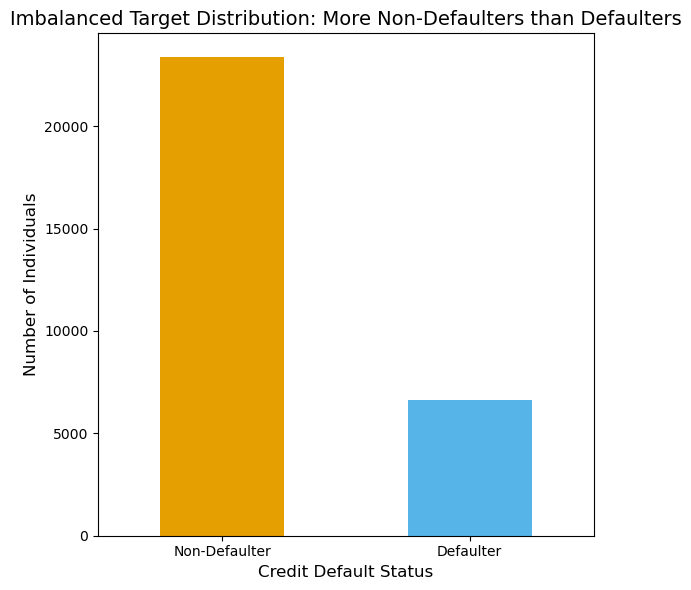

In [13]:
color_palette = ["#E69F00", "#56B4E9"]  # CUD colors or others suitable for color-blind accessibility

plt.figure(figsize=(6, 6))

ax = df2['defaulter'].value_counts().plot(kind='bar', color=color_palette)

plt.title('Imbalanced Target Distribution: More Non-Defaulters than Defaulters', fontsize=14)
plt.xlabel('Credit Default Status', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
ax.set_xticklabels(['Non-Defaulter', 'Defaulter'], rotation=0)
plt.tight_layout()  
plt.savefig('class_imbalance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

Class imbalance in favour of non-defaulters. Will consider resampling techniques to be used in models.

In [15]:
df2.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaulter
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


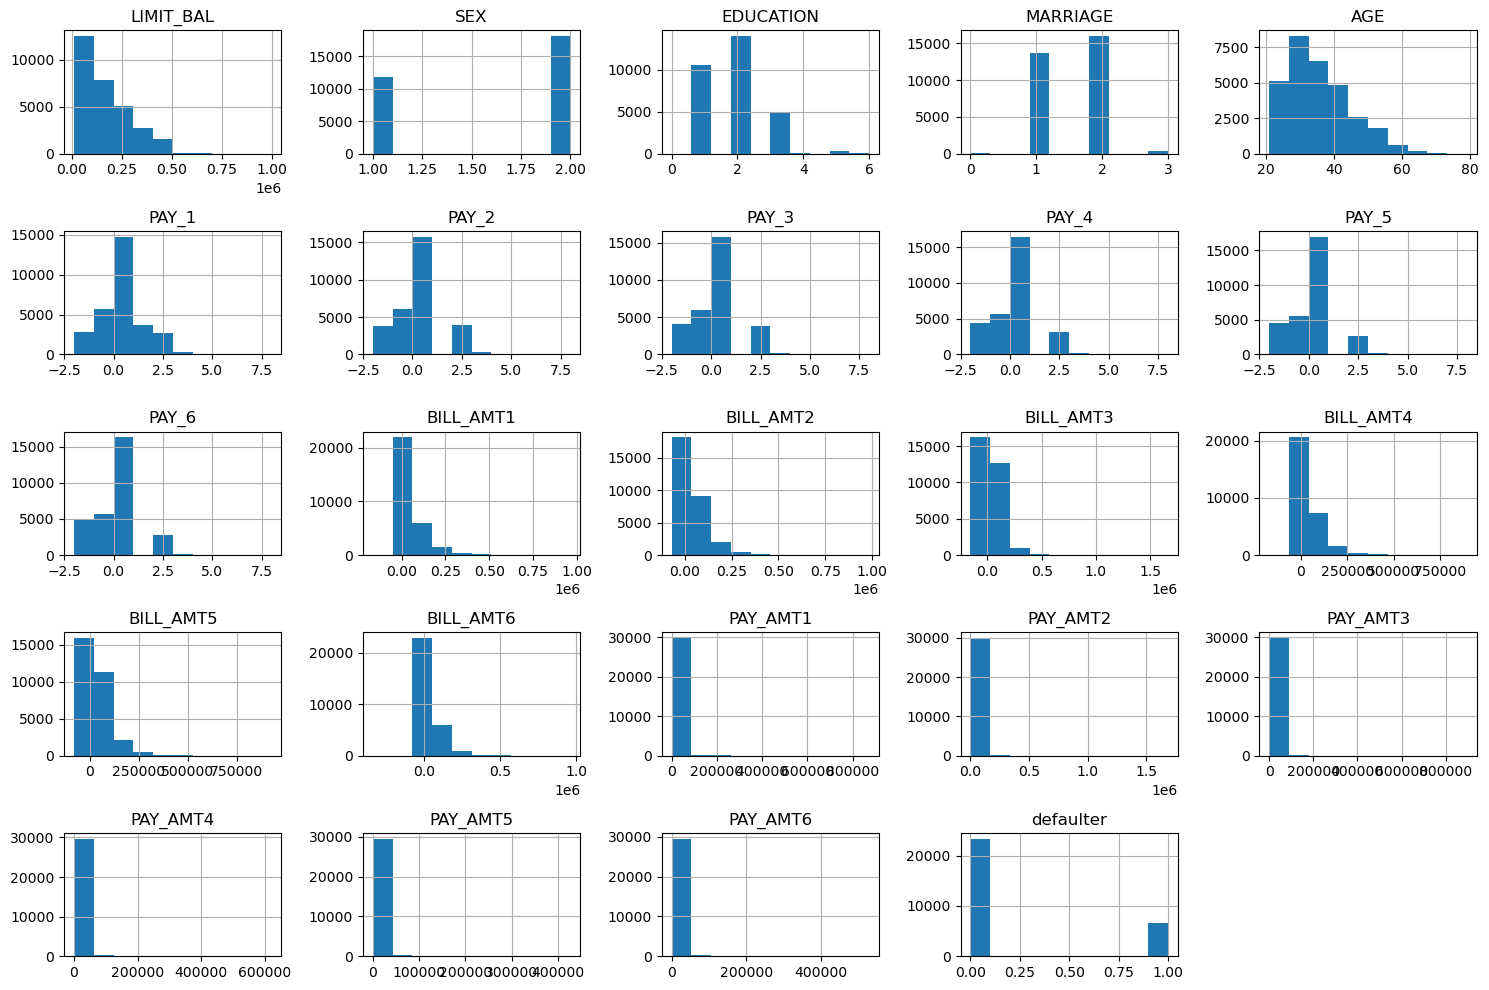

In [16]:
# PLot histogram
df2.hist(figsize=(15,10), grid=True)
plt.tight_layout() 
plt.show()

High-level view of each column shows there are outliers in EDUCATION and MARRIAGE.

In [18]:
# Count occurances
df2['EDUCATION'].value_counts().sort_index()

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [19]:
# Replace column values
df2['EDUCATION'] = df2['EDUCATION'].replace({
    0:4,
    5:4,
    6:4
})

df2['EDUCATION'].value_counts().sort_index()

EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64

In [20]:
# Count occurances
df2['MARRIAGE'].value_counts().sort_index()

MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [21]:
# Replace column values
df2['MARRIAGE'] = df2['MARRIAGE'].replace({
    0:3
})

df2['MARRIAGE'].value_counts().sort_index()

MARRIAGE
1    13659
2    15964
3      377
Name: count, dtype: int64

In [22]:
# Find minimum and maximum age
age_min = df2['AGE'].min()
age_max = df2['AGE'].max()

print(f'Minimum Age: {age_min}\nMaximum Age: {age_max}')

Minimum Age: 21
Maximum Age: 79


Resolved EDUCATION and MARRIAGE. The minimum and maximum AGE seem feasible.

# Data Exploration

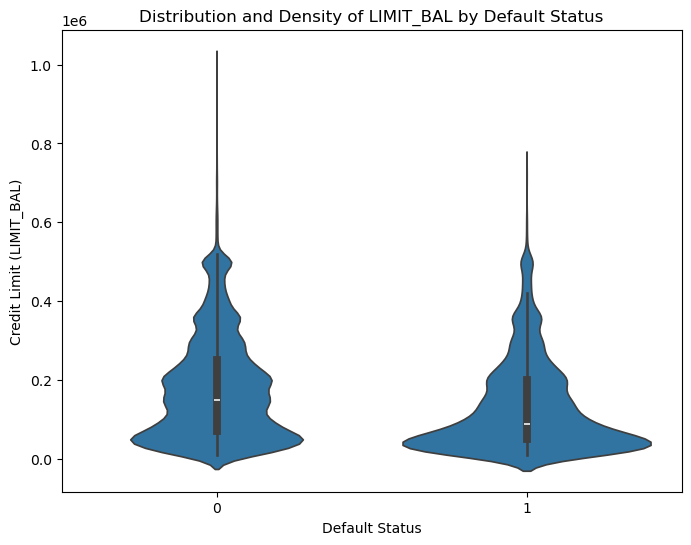

In [25]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df2, x='defaulter', y='LIMIT_BAL')
plt.title("Distribution and Density of LIMIT_BAL by Default Status")
plt.xlabel("Default Status")
plt.ylabel("Credit Limit (LIMIT_BAL)")
plt.show()

Most non-defaulters are paying their credit cards on time and some are paying early. For defaulters, near equal amounts are paying on time as they are taking 2 months to pay the balance.

<Axes: >

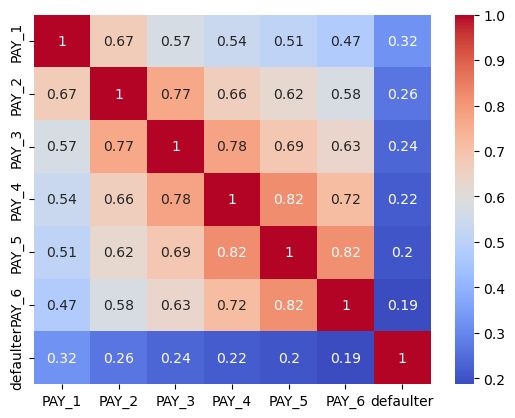

In [27]:
correlation_matrix = df2[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'defaulter']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

Positive feature correlation between repayment status. Prior and next month show highest correlation to one-another.

<Axes: xlabel='SEX', ylabel='count'>

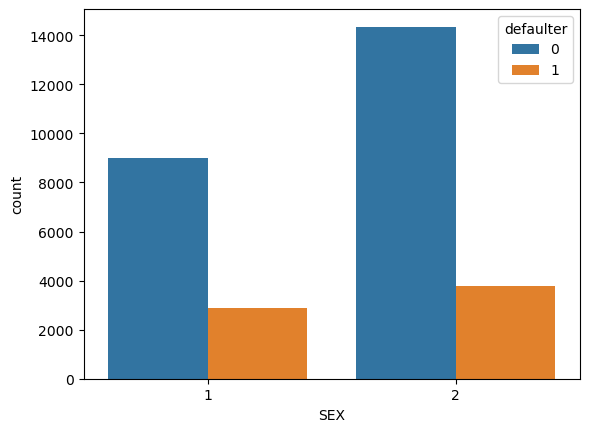

In [29]:
sns.countplot(x='SEX', hue='defaulter', data=df2)

SEX (1=male, 2=female) - More females are not defaulting and defaulting, but this is due to sample size. This feature doesn't seem to make an impact on default status.

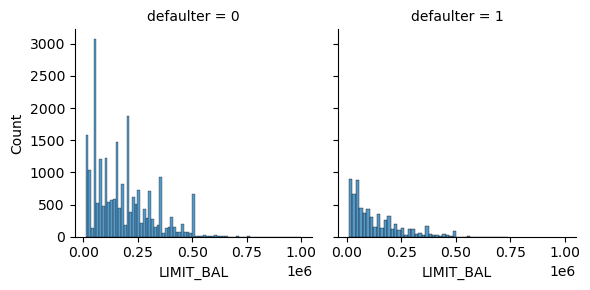

In [31]:
g = sns.FacetGrid(df2, col='defaulter')
g.map(sns.histplot, 'LIMIT_BAL')

Much higher count of individuals for a low range balance limit. Defaulters in lower quantity and seem mostly within greater than zero to 0.25 range.

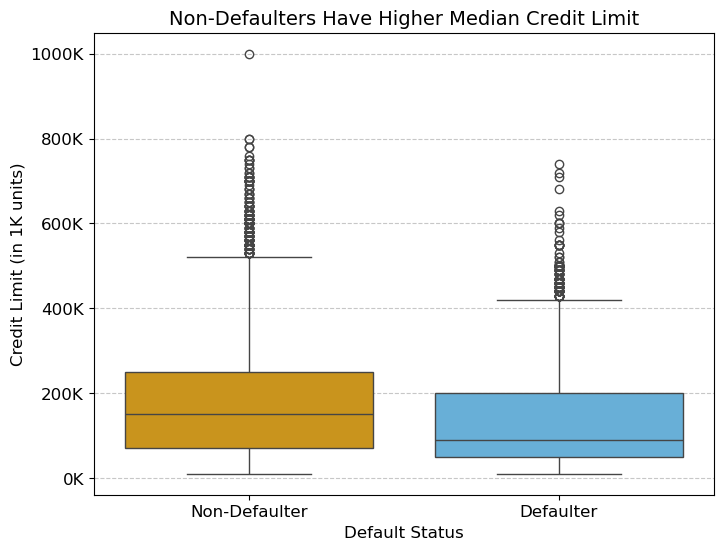

In [33]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=df2, x='defaulter', y='LIMIT_BAL', hue='defaulter', palette=["#E69F00", "#56B4E9"], legend=False)

plt.xlabel("Default Status", fontsize=12, )
plt.ylabel("Credit Limit (in 1K units)", fontsize=12, )
plt.title("Non-Defaulters Have Higher Median Credit Limit", fontsize=14, )
plt.xticks(ticks=[0, 1], labels=["Non-Defaulter", "Defaulter"], fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_yticklabels([f"{int(y/1000)}K" for y in plt.gca().get_yticks()])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('limit_default_box.png', dpi=300)

In [34]:
median_non_defaulter = df2[df2['defaulter'] == 0]['LIMIT_BAL'].median()
median_defaulter = df2[df2['defaulter'] == 1]['LIMIT_BAL'].median()

median_diff = median_non_defaulter - median_defaulter

print(f'Difference between medians: {median_diff}')

Difference between medians: 60000.0


Non-defaulters offered much higher credit limits. Although from view, looks like a 60k difference between medians. Still seems like high values are being afforded to defaulters.

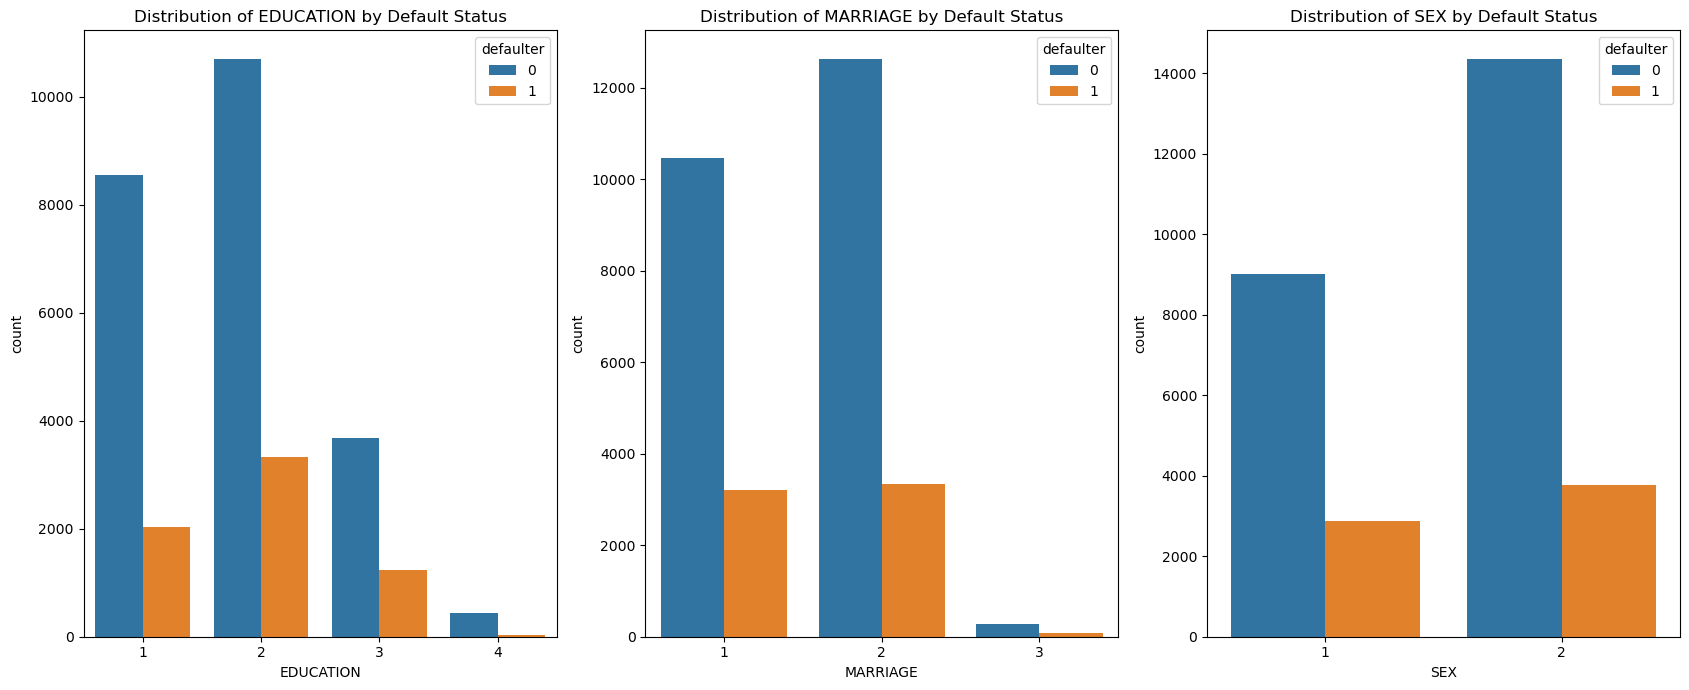

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))  
axes = axes.flatten()  

for i, feature in enumerate(['EDUCATION', 'MARRIAGE', 'SEX']):
    sns.countplot(data=df2, x=feature, hue='defaulter', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Default Status')


plt.tight_layout()
plt.show()

Education: Majority of people aren't defaulters, with the highest non-defaulters being those who have higher education. <br>
Marriage: Similar amounts of defaulters for married and singles, but higher non-defaulters for singles. Likely due to ~2000 more in single samples.
Sex: More females than male in the sample. By proportions, men are defaulting ~3% more than women.

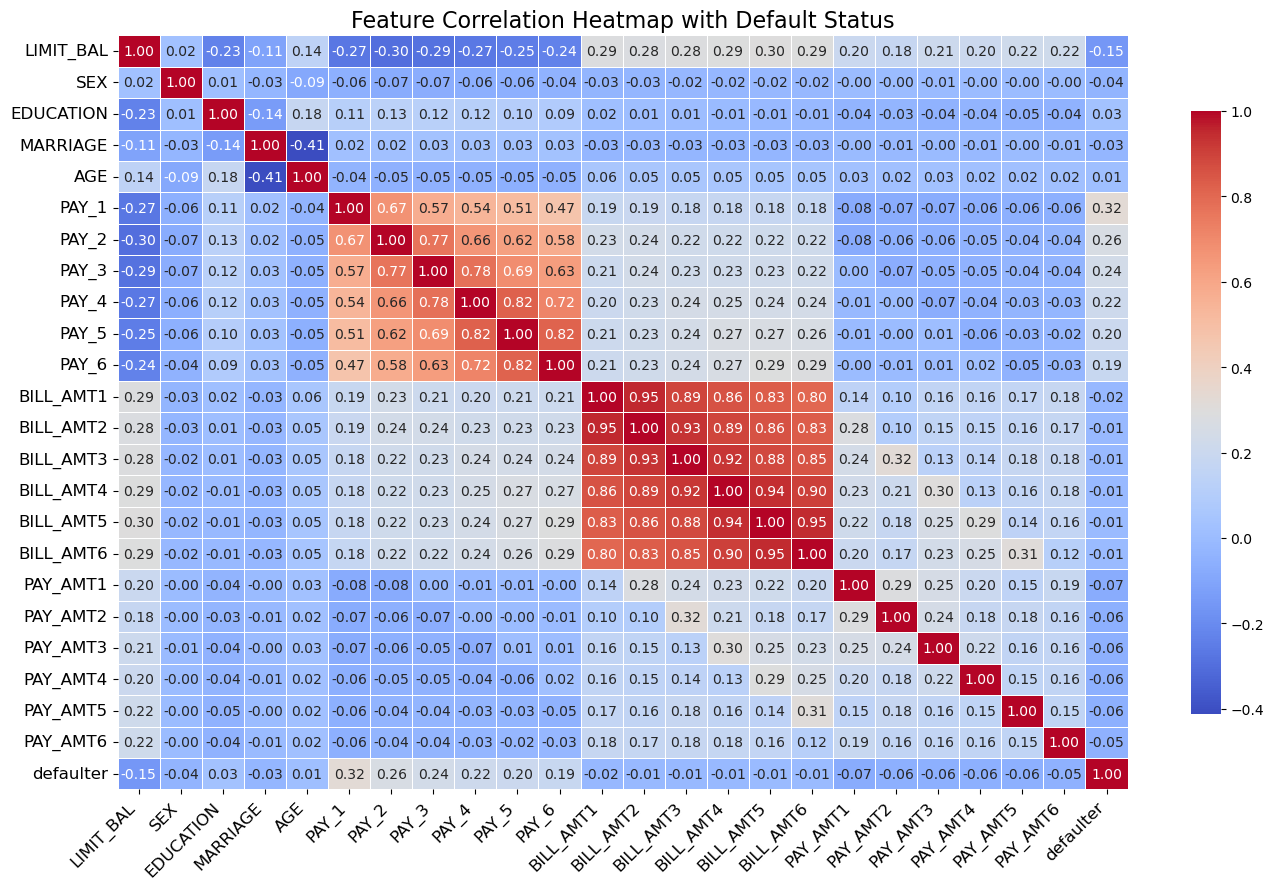

In [38]:
from sklearn.preprocessing import StandardScaler

features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
            'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
            'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
            'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'defaulter']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df2[features])

corr_matrix = pd.DataFrame(scaled_features, columns=features).corr()

plt.figure(figsize=(14, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            annot_kws={"size": 10}, cbar_kws={'shrink': 0.8})  

plt.title("Feature Correlation Heatmap with Default Status", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, ha='right', fontsize=12)
plt.tight_layout()  
plt.show()

Highest correlations from repayment statuses.

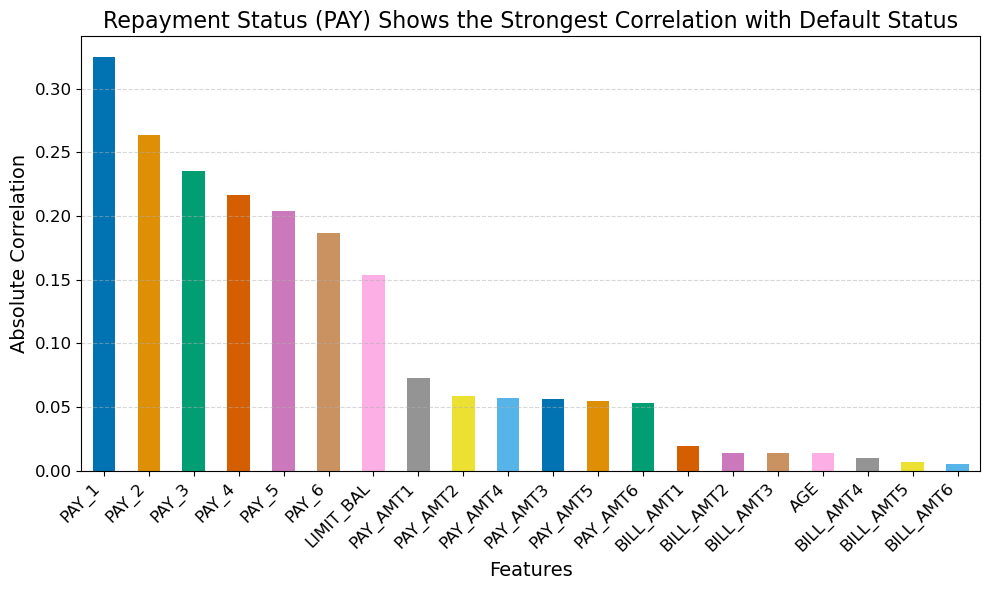

In [40]:
# Select only numeric features for correlation analysis
numeric_features = ['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'defaulter']

corr = df2[numeric_features].corr()
corr_abs = np.abs(corr['defaulter']).drop('defaulter').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.set_palette("colorblind")
corr_abs.plot(kind='bar', color=sns.color_palette("colorblind", n_colors=len(corr_abs)))
plt.title("Repayment Status (PAY) Shows the Strongest Correlation with Default Status", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Absolute Correlation", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('feature_correlation_bar.png', dpi=300, bbox_inches='tight')
plt.show()

Bill amounts show the lowest correlation between the default status.

# Data Pre-processing

In [43]:
df3 = df2.copy()

len(df3.columns)

24

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [45]:
# Assign X and y
X = df3.drop('defaulter', axis=1)
y = df3['defaulter']

In [46]:
# Split data in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 22500 samples
Test set: 7500 samples


In [47]:
continuous_features = ['LIMIT_BAL', 'AGE', 
                       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [48]:
# Scale the continuous data for each dataset
scaler = StandardScaler()

X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

print(X_train.shape) 
print(X_test.shape)

(22500, 23)
(7500, 23)


In [49]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE on training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(X_train_smote.shape)
print(y_train_smote.shape)
print(pd.Series(y_train_smote).value_counts())

(35046, 23)
(35046,)
defaulter
1    17523
0    17523
Name: count, dtype: int64


# Model Comparison Dataframe

In [51]:
model_comparison = pd.DataFrame(columns=['Model', 'SMOTE', 
                                         'Train Score', 'Test Score', 
                                         'Train Precision', 'Test Precision',
                                         'Train Recall', 'Test Recall'])

In [52]:
# Function to add data to comparison dataframe
def add_to_model_comparison(model_comparison, model, smote, train_score, test_score, train_precision, test_precision, train_recall, test_recall):
    new_row = {
        "Model": model, 
        "SMOTE": smote,  
        "Train Score": train_score, 
        "Test Score": test_score, 
        "Train Precision": train_precision, 
        "Test Precision": test_precision, 
        "Train Recall": train_recall, 
        "Test Recall": test_recall
    }

    new_row = {key: value for key, value in new_row.items() if pd.notna(value)}
    model_comparison.loc[len(model_comparison)] = new_row
    model_comparison = model_comparison.drop_duplicates()
    model_comparison.sort_values(by='Model', inplace=True)
    model_comparison.reset_index(drop=True, inplace=True)

    return model_comparison

In [53]:
# Function to compute model metrics and add it to to the dataframe.
def compute_metrics_log(model_comparison, model_name, smote, y_train, y_pred_tr, y_test, y_pred_te):
    Xtr_acc = accuracy_score(y_train, y_pred_tr)
    Xtr_pre = precision_score(y_train, y_pred_tr, zero_division=1)  
    Xtr_rec = recall_score(y_train, y_pred_tr)
    
    Xte_acc = accuracy_score(y_test, y_pred_te)
    Xte_pre = precision_score(y_test, y_pred_te, zero_division=1) 
    Xte_rec = recall_score(y_test, y_pred_te)
    
    #print(f"Train Accuracy:  {Xtr_acc:.4f}")
    #print(f"Train Precision: {Xtr_pre:.4f}")
    #print(f"Train Recall:    {Xtr_rec:.4f}")
    #print("-" * 30)
    #print(f"Test Accuracy:   {Xte_acc:.4f}")
    #print(f"Test Precision:  {Xte_pre:.4f}")
    #print(f"Test Recall:     {Xte_rec:.4f}")

    model_comparison = add_to_model_comparison(model_comparison, model_name, smote, Xtr_acc, Xte_acc, Xtr_pre, Xte_pre, Xtr_rec, Xte_rec)

    return model_comparison

# Modelling with Normal Dataset

## Dummy Classifier

In [56]:
from sklearn.dummy import DummyClassifier

In [57]:
dummy1 = DummyClassifier(strategy='stratified', random_state=42)

dummy1.fit(X_train, y_train)

y_pred_tr = dummy1.predict(X_train)
y_pred_te = dummy1.predict(X_test)

In [58]:
compute_metrics_log(model_comparison, 'Dummy Classifier 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176


Baseline of random classification performs poorly, as expected.

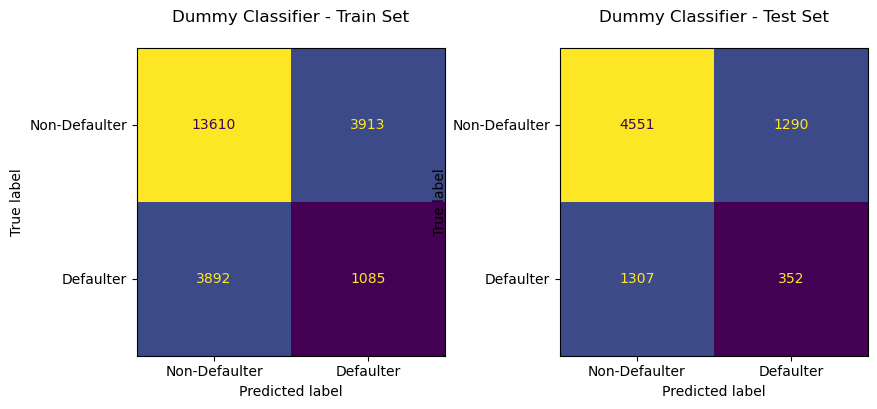

In [60]:
cmat_tr = confusion_matrix(y_train, dummy1.predict(X_train))
cmat_te = confusion_matrix(y_test, dummy1.predict(X_test))

labels = ["Non-Defaulter", "Defaulter"]

train_display = ConfusionMatrixDisplay(cmat_tr, display_labels=labels)
test_display = ConfusionMatrixDisplay(cmat_te, display_labels=labels)

# Plot
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

train_display.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Dummy Classifier - Train Set\n')

test_display.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Dummy Classifier - Test Set\n')

plt.show()

Lots of defaulters are being predicted as non-defaulters, and potential customers being rejected due to high level of false negatives.

## XGBoost

In [63]:
from xgboost import XGBClassifier
import xgboost as xgb

In [64]:
xgb_model1 = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42)

xgb_model1.fit(X_train, y_train)

y_pred_tr = xgb_model1.predict(X_train)
y_pred_te = xgb_model1.predict(X_test)

In [65]:
compute_metrics_log(model_comparison, 'XGBoost 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047


```python
# Parameters
param_grid = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 50, 100]
}

xgb_model2 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model2, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [67]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_model2 = xgb.XGBClassifier(objective='binary:logistic', **best_params, random_state=42)
xgb_model2.fit(X_train, y_train)

y_pred_tr = xgb_model2.predict(X_train)
y_pred_te = xgb_model2.predict(X_test)

In [68]:
compute_metrics_log(model_comparison, 'XGBoost 2', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047


```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4],  # Avoid deeper trees
    'n_estimators': [50, 100, 150],  
    'min_child_weight': [1, 3], 
    'scale_pos_weight': [1, 2],  
}

xgb_model3 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model3, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [70]:
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'scale_pos_weight': 1}

xgb3 = xgb.XGBClassifier(**best_params, random_state=42)
xgb3.fit(X_train, y_train)

y_pred_tr = xgb3.predict(X_train)
y_pred_te = xgb3.predict(X_test)

In [71]:
compute_metrics_log(model_comparison, 'XGBoost 3', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814


Test accuracy and precision have increased slightly, but recall has decreased. I'll adjust the parameters one final time to see if I can get a bit more improvement in perforamance.

```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [2, 3],  
    'n_estimators': [50, 100],  
    'min_child_weight': [1],  # Allow more splits to capture patterns  
    'scale_pos_weight': [1, 3, 5],  # Push model toward detecting more positives  
}

xgb_model4 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model4, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [74]:
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'scale_pos_weight': 1}

xgb4 = xgb.XGBClassifier(**best_params, random_state=42)
xgb4.fit(X_train, y_train)

y_pred_tr = xgb4.predict(X_train)
y_pred_te = xgb4.predict(X_test)

In [75]:
compute_metrics_log(model_comparison, 'XGBoost 4', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417


These parameters show improvement from XBG3 to XBG4. Will now adjust the parameters in an attempt to increase recall further.

```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4],  
    'n_estimators': [100, 150], 
    'min_child_weight': [1, 2],  
    'scale_pos_weight': [3, 5], 
}

xgb_model5 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model5, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [78]:
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'scale_pos_weight': 3}

xgb5 = xgb.XGBClassifier(**best_params, random_state=42)
xgb5.fit(X_train, y_train)

y_pred_tr = xgb5.predict(X_train)
y_pred_te = xgb5.predict(X_test)

In [79]:
compute_metrics_log(model_comparison, 'XGBoost 5', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770


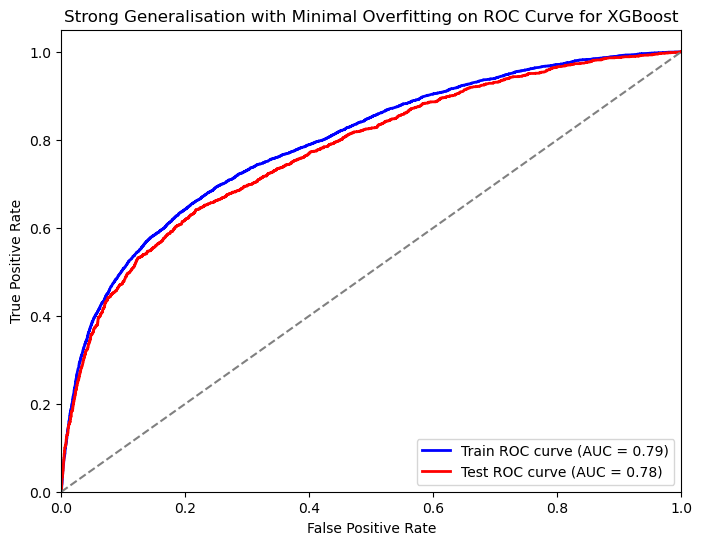

In [80]:
from sklearn.metrics import roc_curve, auc

y_prob_tr = xgb5.predict_proba(X_train)[:, 1]
y_prob_te = xgb5.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_prob_tr)
fpr_te, tpr_te, _ = roc_curve(y_test, y_prob_te)

roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_te = auc(fpr_te, tpr_te)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tr, tpr_tr, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_tr:.2f})')
plt.plot(fpr_te, tpr_te, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_te:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Strong Generalisation with Minimal Overfitting on ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.savefig('xgb_model_roc.png', dpi=300, bbox_inches='tight')
plt.show()

Good model generalisation and only a 0.01 decrease from the train to the test dataset.

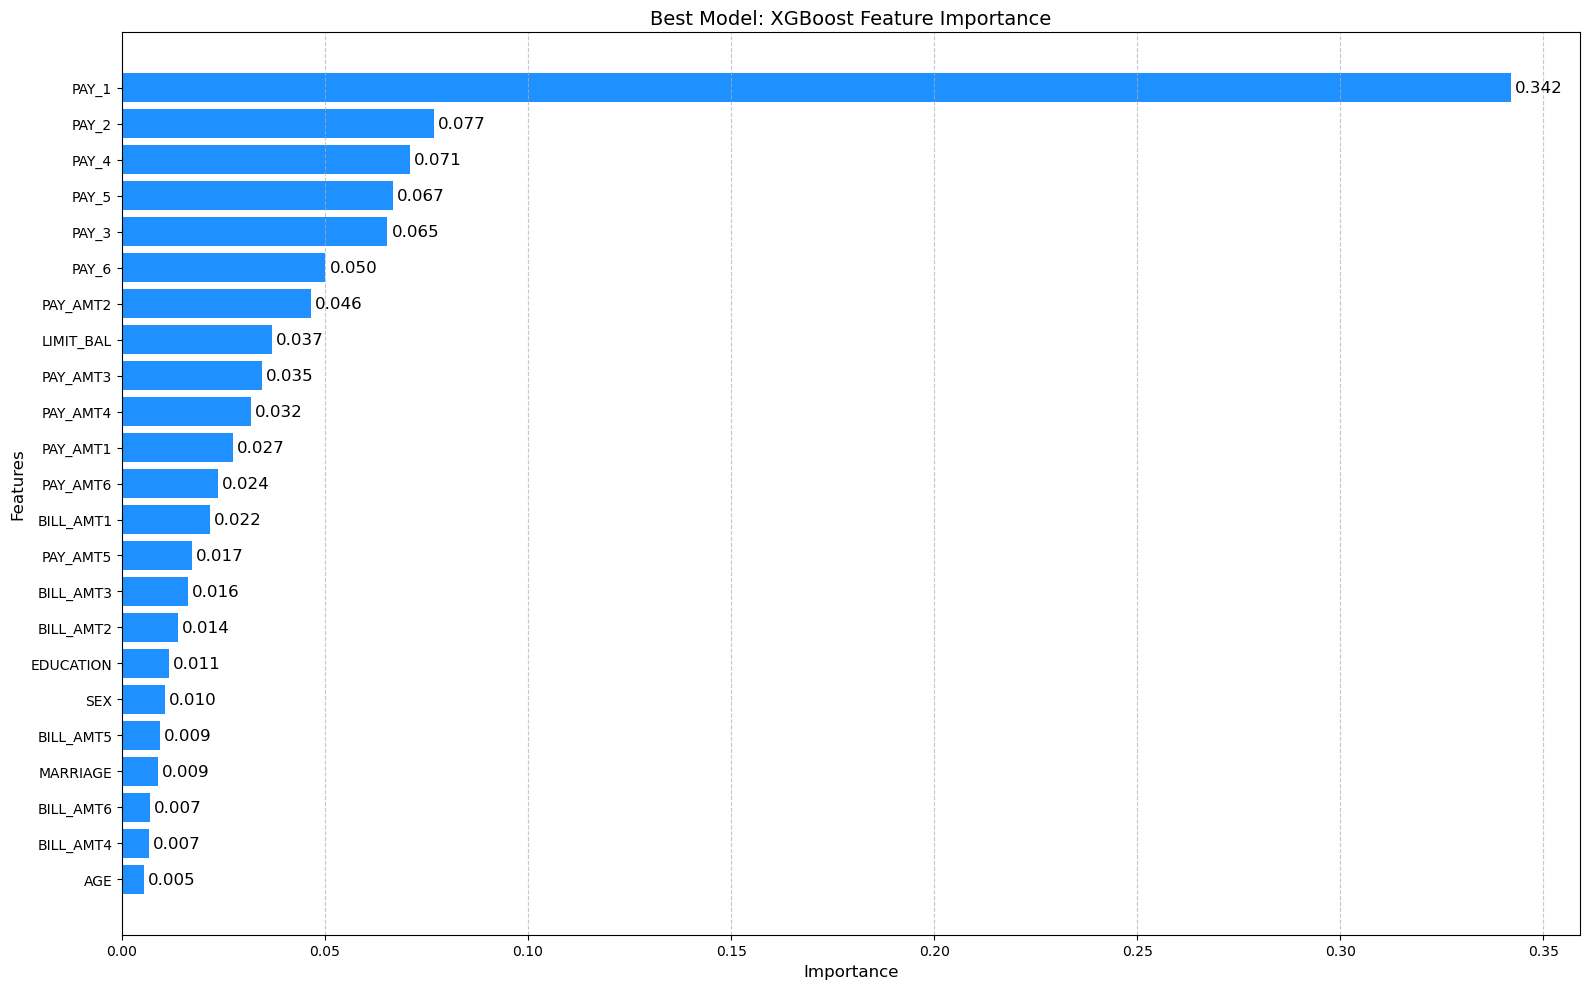

In [82]:
importance = xgb5.feature_importances_

feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(16, 10))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='dodgerblue')

offset = 0.001
for bar in bars:
    plt.text(bar.get_width() + offset, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=12, color='black')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Best Model: XGBoost Feature Importance', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('xgboot_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

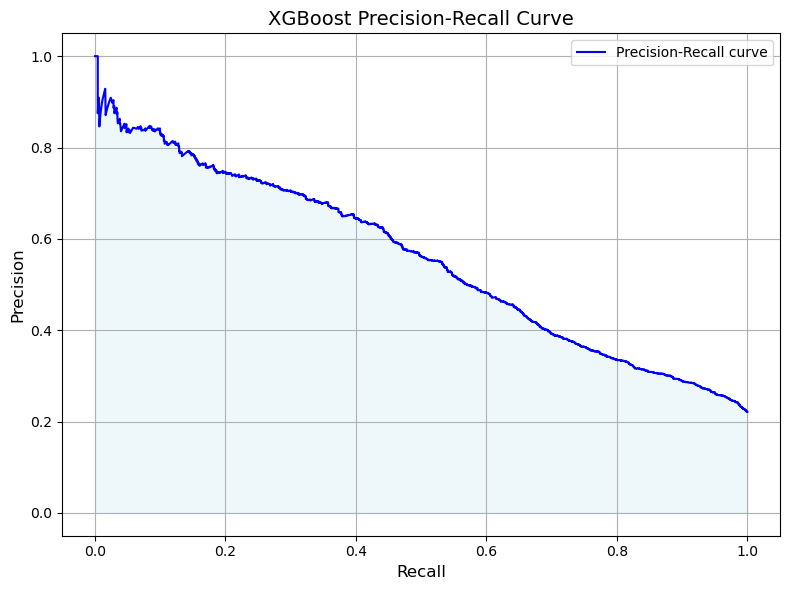

In [83]:
from sklearn.metrics import precision_recall_curve

y_prob = xgb5.predict_proba(X_test)[:, 1]  

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, alpha=0.2, color='lightblue')

plt.title(f'XGBoost Precision-Recall Curve', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('xgboot_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

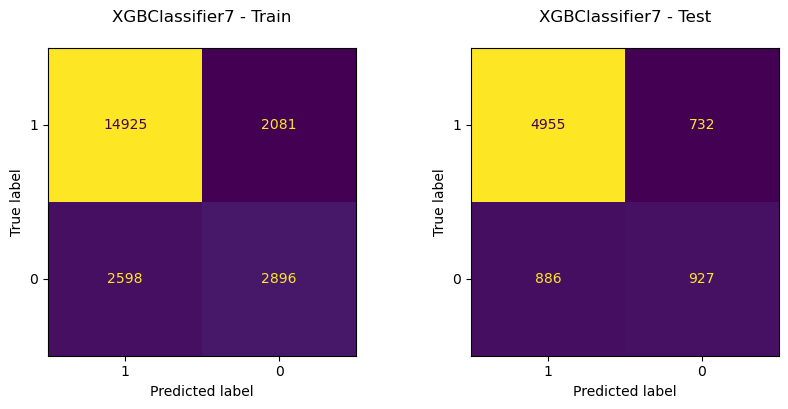

In [84]:
cmat_tr = confusion_matrix(xgb5.predict(X_train), y_train)
cmat_te = confusion_matrix(xgb5.predict(X_test), y_test)

train_display = ConfusionMatrixDisplay(cmat_tr, display_labels=y_train.unique().tolist())
test_display = ConfusionMatrixDisplay(cmat_te, display_labels=y_train.unique().tolist())

plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

train_display.plot(ax = ax[0], colorbar = False)
ax[0].set_title('XGBClassifier7 - Train\n')

test_display.plot(ax = ax[1], colorbar = False)
ax[1].set_title('XGBClassifier7 - Test\n')

plt.show()

Still a large sum false negatives. But good model perfomance so far on XGB5 in terms of balance in precision and recall.

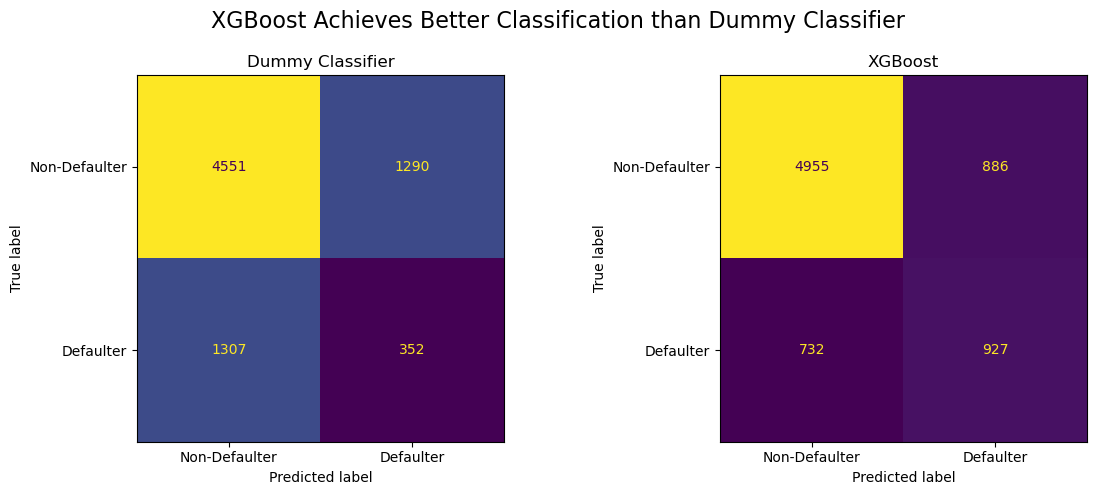

In [86]:
cmat_dummy = confusion_matrix(y_test, dummy1.predict(X_test))
cmat_xgb = confusion_matrix(y_test, xgb5.predict(X_test))

labels = ["Non-Defaulter", "Defaulter"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Dummy classifier confusion matrix
dummy_display = ConfusionMatrixDisplay(cmat_dummy, display_labels=labels)
dummy_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Dummy Classifier')

# XGBoost confusion matrix
xgb_display = ConfusionMatrixDisplay(cmat_xgb, display_labels=labels)
xgb_display.plot(ax=axes[1], colorbar=False)
axes[1].set_title('XGBoost')

plt.suptitle('XGBoost Achieves Better Classification than Dummy Classifier', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  
plt.savefig('conf_matrix_dummy_xgb7.png', dpi=300, bbox_inches='tight')
plt.show()

Performs far better than the dummy classifier. More TN and TP.

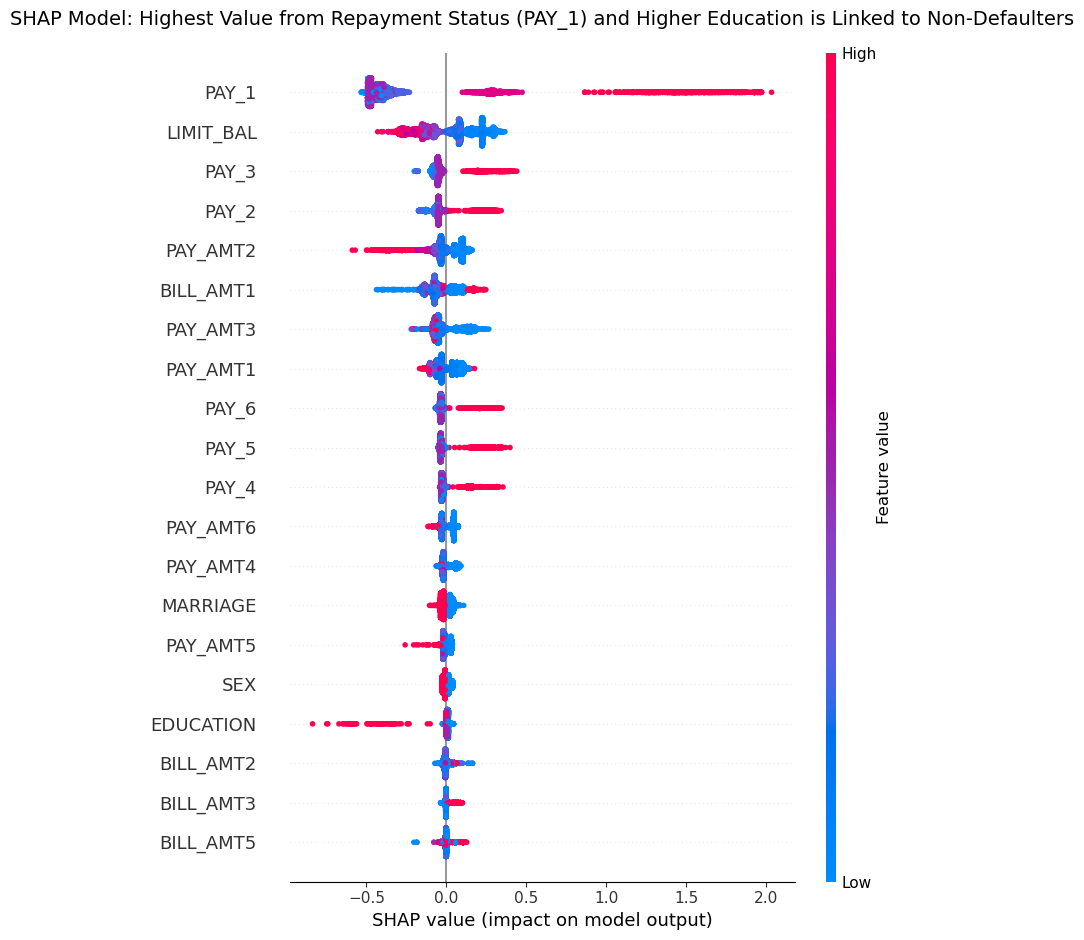

In [88]:
import shap

explainer = shap.TreeExplainer(xgb5)
shap_values = explainer.shap_values(X_test)

fig = plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)  

plt.title('SHAP Model: Highest Value from Repayment Status (PAY_1) and Higher Education is Linked to Non-Defaulters', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Strong correlation of the Sept repayment status and surprising value of education when the correlation in the data exploration showed it to be neglible in comparison to others.

```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4],  
    'n_estimators': [100, 150],  
    'min_child_weight': [1],  
    'scale_pos_weight': [2, 2.5],  

xgb_model6 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model6, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [91]:
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 2}

xgb6 = xgb.XGBClassifier(**best_params, random_state=42)
xgb6.fit(X_train, y_train)

y_pred_tr = xgb6.predict(X_train)
y_pred_te = xgb6.predict(X_test)

In [92]:
compute_metrics_log(model_comparison, 'XGBoost 6', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
6,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710


In the next model, I'm going to find the parameters to boost recall as far as possible.

```python
param_grid = {
    'learning_rate': [0.01, 0.05], 
    'max_depth': [3, 4],  
    'n_estimators': [100, 200, 300],  
    'min_child_weight': [1, 2, 3],  
    'scale_pos_weight': [2, 3, 5]
}

xgb_model7 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model7, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)

In [95]:
best_params = {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 2}

xgb7 = xgb.XGBClassifier(**best_params, random_state=42)
xgb7.fit(X_train, y_train)

y_pred_tr = xgb7.predict(X_train)
y_pred_te = xgb7.predict(X_test)

In [96]:
compute_metrics_log(model_comparison, 'XGBoost 7', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
6,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
7,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980


That didn't perform well for recall, but it increased the score and precision.

```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [4, 6, 8], 
    'n_estimators': [100, 150, 200],  
    'scale_pos_weight': [2, 3, 4], 
    'min_child_weight': [1, 2],
}

xgb_model8 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model8, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test

In [99]:
best_params = {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'scale_pos_weight': 2}

xgb8 = xgb.XGBClassifier(**best_params, random_state=42)
xgb8.fit(X_train, y_train)

y_pred_tr = xgb8.predict(X_train)
y_pred_te = xgb8.predict(X_test)

In [100]:
compute_metrics_log(model_comparison, 'XGBoost 8', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
6,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
7,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980
8,XGBoost 8,0,0.821467,0.809333,0.619641,0.585257,0.499498,0.473779


Recall has started to improve now, so it's on the right track. But nowhere near as well as Model: XGBoost 5 in terms of best recall and balance with precision too. Accuracy score has decreased significanty, but due to the class imbalance it's not a reliable metric and an increase in recall will cause a decrease in accuracy score.

## Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
rf1 = RandomForestClassifier(random_state=42)

rf1.fit(X_train, y_train)

y_pred_tr = rf1.predict(X_train)
y_pred_te = rf1.predict(X_test)

In [105]:
compute_metrics_log(model_comparison, 'Random Forest 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500
2,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
3,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
4,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
5,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
6,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
7,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
8,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980
9,XGBoost 8,0,0.821467,0.809333,0.619641,0.585257,0.499498,0.473779


This random forest model massively overfits to the train data. Hyperparameter tuning will be used to reduce this.

```python
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

rf2 = RandomForestClassifier(random_state=42)

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

best_params = {}

for metric in scoring_metrics:
    grid_search = GridSearchCV(rf2, param_grid, cv=5, scoring=metric, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_params[metric] = {
        "params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

for metric, result in best_params.items():
    print(f"Best {metric.upper()} Params: {result['params']}")
    print(f"Best {metric.upper()} Score: {result['best_score']:.4f}\n")

In [108]:
best_acc_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

rf2 = RandomForestClassifier(**best_acc_params, random_state=42)
rf2.fit(X_train, y_train)

y_pred_tr = rf2.predict(X_train)
y_pred_te = rf2.predict(X_test)

In [109]:
compute_metrics_log(model_comparison, 'Random Forest 2', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500
2,Random Forest 2,0,0.853689,0.816133,0.813780,0.656600,0.439019,0.353828
3,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
4,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
5,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
6,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
7,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
8,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
9,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980


In [110]:
best_reca_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

rf3 = RandomForestClassifier(**best_reca_params, random_state=42)
rf3.fit(X_train, y_train)

y_pred_tr = rf3.predict(X_train)
y_pred_te = rf3.predict(X_test)

In [111]:
compute_metrics_log(model_comparison, 'Random Forest 3', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500
2,Random Forest 2,0,0.853689,0.816133,0.813780,0.656600,0.439019,0.353828
3,Random Forest 3,0,0.985911,0.817867,0.996802,0.650565,0.939321,0.381555
4,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
5,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
6,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
7,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
8,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
9,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710


## KNN

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
knn1 = KNeighborsClassifier()

knn1.fit(X_train, y_train)

y_pred_tr = knn1.predict(X_train)
y_pred_te = knn1.predict(X_test)

In [115]:
compute_metrics_log(model_comparison, 'KNN 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
2,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500
3,Random Forest 2,0,0.853689,0.816133,0.813780,0.656600,0.439019,0.353828
4,Random Forest 3,0,0.985911,0.817867,0.996802,0.650565,0.939321,0.381555
5,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
6,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
7,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
8,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
9,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770


```python
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

knn = KNeighborsClassifier(random_state=42)
grid_search_acc = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_acc.fit(X_train, y_train)

best_params_acc = grid_search_acc.best_params_
best_score_acc = grid_search_acc.best_score_

print(best_params_acc)
print(best_score_acc)

knn = KNeighborsClassifier(random_state=42)
grid_search_pre = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search_pre.fit(X_train, y_train)

best_params_pre = grid_search_pre.best_params_
best_score_pre = grid_search_pre.best_score_

print(best_params_pre)
print(best_score_pre)

In [117]:
best_params_acc = {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
best_params_f1 = {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

knn_best_params = [best_params_acc, best_params_f1]

counter = 2

for params in knn_best_params:
    knn = KNeighborsClassifier(**params)
    knn.fit(X_train, y_train)
    
    y_pred_tr = knn.predict(X_train)
    y_pred_te = knn.predict(X_test)

    model_name = f'KNN {counter}'
    counter += 1

    compute_metrics_log(model_comparison, model_name, 0, y_train, y_pred_tr, y_test, y_pred_te)

## Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
log_model1 = LogisticRegression(random_state=42)

log_model1.fit(X_train, y_train)

y_pred_tr = log_model1.predict(X_train)
y_pred_te = log_model1.predict(X_test)

In [121]:
compute_metrics_log(model_comparison, 'Logistic Regression 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
2,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
3,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
4,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
5,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500
6,Random Forest 2,0,0.853689,0.816133,0.813780,0.656600,0.439019,0.353828
7,Random Forest 3,0,0.985911,0.817867,0.996802,0.650565,0.939321,0.381555
8,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
9,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047


```python
scoring_methods = ['accuracy', 'precision', 'recall', 'f1']
best_params = {}
best_scores = {}

for score in scoring_methods:
    log_reg = LogisticRegression(random_state=42)

    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params[score] = grid_search.best_params_
    best_scores[score] = grid_search.best_score_
    
    print(f"Best Params for {score}: {best_params[score]}")
    print(f"Best {score} Score: {best_scores[score]:.4f}")

In [123]:
# Best parameters from code output above.
best_params = {
    'accuracy': {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'},
    'precision': {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'},
    'recall': {'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
    'f1': {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
}

counter = 2

for score in best_params:
    params = best_params[score]  
    
    log_reg = LogisticRegression(**params, random_state=42)
    log_reg.fit(X_train, y_train)
    
    y_pred_tr = log_reg.predict(X_train)
    y_pred_te = log_reg.predict(X_test)

    model_name = f'Logistic Regression {counter}'
    counter += 1
    
    compute_metrics_log(model_comparison, model_name, 0, y_train, y_pred_tr, y_test, y_pred_te)

## SVM

In [125]:
from sklearn.svm import SVC

In [126]:
svc_model1 = SVC(random_state=42)

svc_model1.fit(X_train, y_train)

y_pred_tr = svc_model1.predict(X_train)
y_pred_te = svc_model1.predict(X_test)

In [127]:
compute_metrics_log(model_comparison, 'SVC 1', 0, y_train, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
2,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
3,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
4,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
5,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
6,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
8,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916
9,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500


SVC test precision is quite high for a basic model, however recall, which is a focus, is very poor.

# Modelling with SMOTE Dataset

## Dummy Classifier

In [131]:
dummy2 = DummyClassifier(strategy='stratified', random_state=42)

dummy2.fit(X_train_smote, y_train_smote)

y_pred_tr = dummy2.predict(X_train_smote)
y_pred_te = dummy2.predict(X_test)

In [132]:
compute_metrics_log(model_comparison, 'Dummy Classifier 2', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


Dummy Classifier with SMOTE shows improvement in test recall. But this is likely due to the larger number of defaulter class to make a balance with the non-defaulters now. It is still random selection.

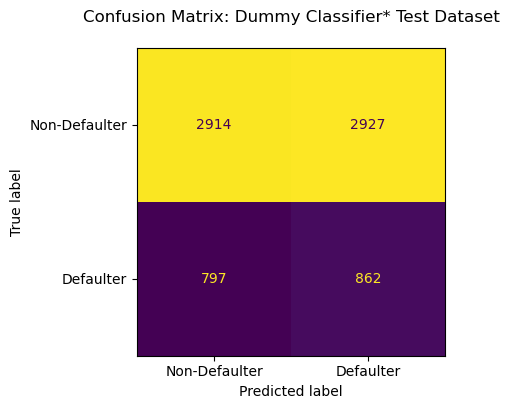

In [134]:
cmat_te = confusion_matrix(y_test, dummy2.predict(X_test))

labels = ["Non-Defaulter", "Defaulter"]

test_display = ConfusionMatrixDisplay(cmat_te, display_labels=labels)

sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(10, 4)) 
test_display.plot(ax=ax, colorbar=False)  
ax.set_title('Confusion Matrix: Dummy Classifier* Test Dataset\n')
plt.savefig('conf_matrix_dummy_smote.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
model_comparison

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
6,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
7,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980
8,XGBoost 8,0,0.821467,0.809333,0.619641,0.585257,0.499498,0.473779
9,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500


## XGBoost

In [137]:
xgb_model9 = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42)

xgb_model9.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb_model9.predict(X_train_smote)
y_pred_te = xgb_model9.predict(X_test)

In [138]:
compute_metrics_log(model_comparison, 'XGBoost 9', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [10, 50, 100]
}

xgb_model10 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model10, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [140]:
best_params = {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}

xgb10 = xgb.XGBClassifier(**best_params, random_state=42)
xgb10.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb10.predict(X_train_smote)
y_pred_te = xgb10.predict(X_test)

In [141]:
compute_metrics_log(model_comparison, 'XGBoost 10', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
# Parameters to search
param_grid = {
    'learning_rate': [0.1, 0.3],  
    'max_depth': [1, 3, 5], 
    'n_estimators': [50, 100],  
    'subsample': [0.8],  
    'colsample_bytree': [0.8], 
    'min_child_weight': [1, 5], 
    'scale_pos_weight': [1, 2],  
}

xgb_model11 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model11, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [143]:
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 
               'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.8}

xgb11 = xgb.XGBClassifier(**best_params, random_state=42)
xgb11.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb11.predict(X_train_smote)
y_pred_te = xgb11.predict(X_test)

In [144]:
compute_metrics_log(model_comparison, 'XGBoost 11', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


It looks like with the SMOTE data, the models are performing much better on the train data and worse in the test data in comparison to the normal data. This suggests overfitting.

```python
xgb_model12 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model12, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [147]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'scale_pos_weight': 1}

xgb12 = xgb.XGBClassifier(**best_params, random_state=42)
xgb12.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb12.predict(X_train_smote)
y_pred_te = xgb12.predict(X_test)

In [148]:
compute_metrics_log(model_comparison, 'XGBoost 12', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [2, 3],  
    'n_estimators': [50, 100],  
    'min_child_weight': [1],    
    'scale_pos_weight': [1, 3, 5],   
}

xgb_model13 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model13, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [150]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1}

xgb13 = xgb.XGBClassifier(**best_params, random_state=42)
xgb13.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb13.predict(X_train_smote)
y_pred_te = xgb13.predict(X_test)

In [151]:
compute_metrics_log(model_comparison, 'XGBoost 13', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4],  
    'n_estimators': [100, 150], 
    'min_child_weight': [1, 2],  
    'scale_pos_weight': [3, 5],  
}

xgb_model14 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model14, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [153]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'scale_pos_weight': 3}

xgb14 = xgb.XGBClassifier(**best_params, random_state=42)
xgb14.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb14.predict(X_train_smote)
y_pred_te = xgb14.predict(X_test)

In [154]:
compute_metrics_log(model_comparison, 'XGBoost 14', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


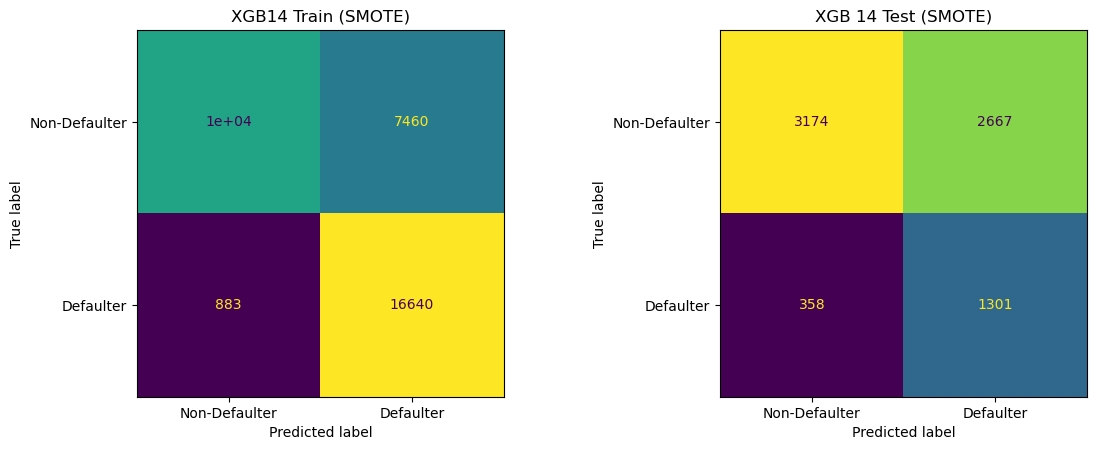

In [155]:
cmat_xgb_tr = confusion_matrix(y_train_smote, xgb14.predict(X_train_smote))
cmat_xgb_te = confusion_matrix(y_test, xgb14.predict(X_test))

labels = ["Non-Defaulter", "Defaulter"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

train_display = ConfusionMatrixDisplay(cmat_xgb_tr, display_labels=labels)
train_display.plot(ax=axes[0], colorbar=False)
axes[0].set_title('XGB14 Train (SMOTE)')

xgb_display = ConfusionMatrixDisplay(cmat_xgb_te, display_labels=labels)
xgb_display.plot(ax=axes[1], colorbar=False)
axes[1].set_title('XGB 14 Test (SMOTE)')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  
plt.show()

Best model so far in terms of TN. If this was the only concern, this would be the best model. But a large amount of potential customers are being rejected in FN. And the best recall score of 0.78.

```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 4], 
    'n_estimators': [100, 150], 
    'min_child_weight': [1],  
    'scale_pos_weight': [2, 2.5],  
}

xgb_model15 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model15, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [158]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'scale_pos_weight': 2}

xgb15 = xgb.XGBClassifier(**best_params, random_state=42)
xgb15.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb15.predict(X_train_smote)
y_pred_te = xgb15.predict(X_test)

In [159]:
compute_metrics_log(model_comparison, 'XGBoost 15', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'learning_rate': [0.01, 0.05], 
    'max_depth': [3, 4], 
    'n_estimators': [100, 200, 300],  
    'min_child_weight': [1, 2, 3],  
    'scale_pos_weight': [2, 3, 5],  
}

xgb_model16 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model16, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [161]:
best_params = {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'scale_pos_weight': 2}

xgb16 = xgb.XGBClassifier(**best_params, random_state=42)
xgb16.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb16.predict(X_train_smote)
y_pred_te = xgb16.predict(X_test)

In [162]:
compute_metrics_log(model_comparison, 'XGBoost 16', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'learning_rate': [0.05, 0.1],  
    'max_depth': [4, 6, 8],  
    'n_estimators': [100, 150, 200],  
    'scale_pos_weight': [2, 3, 4],  
    'min_child_weight': [1, 2], 
}

xgb_model17 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model17, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")
best_model = grid_search.best_estimator_

y_pred_tr = best_model.predict(X_train_smote)
y_pred_te = best_model.predict(X_test)

In [164]:
best_params = {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 2}

xgb17 = xgb.XGBClassifier(**best_params, random_state=42)
xgb17.fit(X_train_smote, y_train_smote)

y_pred_tr = xgb17.predict(X_train_smote)
y_pred_te = xgb17.predict(X_test)

In [165]:
compute_metrics_log(model_comparison, 'XGBoost 17', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


## Random Forest

In [167]:
rf4 = RandomForestClassifier(random_state=42)

rf4.fit(X_train_smote, y_train_smote)

y_pred_tr = rf4.predict(X_train_smote)
y_pred_te = rf4.predict(X_test)

In [168]:
compute_metrics_log(model_comparison, 'Random Forest 4', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


```python
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

rf5 = RandomForestClassifier(random_state=42)

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

best_params = {}

for metric in scoring_metrics:
    grid_search = GridSearchCV(rf5, param_grid, cv=5, scoring=metric, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_params[metric] = {
        "params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

for metric, result in best_params.items():
    print(f"Best {metric.upper()} Params: {result['params']}")
    print(f"Best {metric.upper()} Score: {result['best_score']:.4f}\n")

In [170]:
best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

rf5 = RandomForestClassifier(**best_params, random_state=42)
rf5.fit(X_train_smote, y_train_smote)

y_pred_tr = rf5.predict(X_train_smote)
y_pred_te = rf5.predict(X_test)

In [171]:
compute_metrics_log(model_comparison, 'Random Forest 5', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


In [172]:
best_tested_params = {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

rf6 = RandomForestClassifier(**best_tested_params, random_state=42)
rf6.fit(X_train_smote, y_train_smote)

y_pred_tr = rf6.predict(X_train_smote)
y_pred_te = rf6.predict(X_test)

In [173]:
compute_metrics_log(model_comparison, 'Random Forest 6', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
6,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
7,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103
9,Logistic Regression 5,0,0.582311,0.577467,0.311278,0.306509,0.732570,0.720916


## KNN

In [175]:
knn4 = KNeighborsClassifier()

knn4.fit(X_train_smote, y_train_smote)

y_pred_tr = knn4.predict(X_train_smote)
y_pred_te = knn4.predict(X_test)

In [176]:
compute_metrics_log(model_comparison, 'KNN 4', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,KNN 4,1,0.860726,0.660133,0.803515,0.348019,0.954973,0.614225
6,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
7,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
8,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
9,Logistic Regression 4,0,0.692356,0.680400,0.383770,0.369703,0.645168,0.631103


```python
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

scoring_methods = ['accuracy', 'precision', 'recall', 'f1']
best_params = {}
best_scores = {}

for score in scoring_methods:
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)

    best_params[score] = grid_search.best_params_
    best_scores[score] = grid_search.best_score_

    print(f"Best Params for {score}: {best_params[score]}")
    print(f"Best {score} Score: {best_scores[score]:.4f}")

In [178]:
best_params = {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} 

knn5 = KNeighborsClassifier(**best_params)
knn5.fit(X_train_smote, y_train_smote)

y_pred_tr = knn5.predict(X_train_smote)
y_pred_te = knn5.predict(X_test)

In [179]:
compute_metrics_log(model_comparison, 'KNN 5', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,KNN 4,1,0.860726,0.660133,0.803515,0.348019,0.954973,0.614225
6,KNN 5,1,0.999686,0.660933,0.999943,0.340433,0.999429,0.568415
7,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
8,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
9,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659


## Logistic Regression

In [181]:
log_model6 = LogisticRegression(random_state=42)

log_model6.fit(X_train_smote, y_train_smote)

y_pred_tr = log_model6.predict(X_train_smote)
y_pred_te = log_model6.predict(X_test)

In [182]:
compute_metrics_log(model_comparison, 'Logistic Regression 6', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,KNN 4,1,0.860726,0.660133,0.803515,0.348019,0.954973,0.614225
6,KNN 5,1,0.999686,0.660933,0.999943,0.340433,0.999429,0.568415
7,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
8,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659
9,Logistic Regression 3,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659


```python
scoring_methods = ['accuracy', 'precision', 'recall', 'f1']
best_params = {}
best_scores = {}

for score in scoring_methods:
    log_reg = LogisticRegression(random_state=42)

    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)

    best_params[score] = grid_search.best_params_
    best_scores[score] = grid_search.best_score_
    
    print(f"Best Params for {score}: {best_params[score]}")
    print(f"Best {score} Score: {best_scores[score]:.4f}")

In [184]:
best_params = {
    'accuracy': {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'},
    'precision': {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'},
    'recall': {'C': 100, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'},
    'f1': {'C': 100, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
}

counter = 7

for score in best_params:
    params = best_params[score]  
    
    log_reg = LogisticRegression(**params, random_state=42)
    log_reg.fit(X_train_smote, y_train_smote)
    
    y_pred_tr = log_reg.predict(X_train_smote)
    y_pred_te = log_reg.predict(X_test)

    model_name = f'Logistic Regression {counter}'
    counter += 1
    
    compute_metrics_log(model_comparison, model_name, 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

## SVM

In [186]:
svc_model2 = SVC(random_state=42)

svc_model2.fit(X_train_smote, y_train_smote)

y_pred_tr = svc_model2.predict(X_train_smote)
y_pred_te = svc_model2.predict(X_test)

In [187]:
compute_metrics_log(model_comparison, 'SVC 2', 1, y_train_smote, y_pred_tr, y_test, y_pred_te)

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,Dummy Classifier 2,1,0.500713,0.503467,0.500714,0.227501,0.500200,0.519590
2,KNN 1,0,0.845556,0.795333,0.728545,0.558380,0.481013,0.357444
3,KNN 2,0,0.828489,0.809600,0.699074,0.622742,0.394414,0.353225
4,KNN 3,0,0.999511,0.775200,0.999799,0.489765,0.997991,0.389391
5,KNN 4,1,0.860726,0.660133,0.803515,0.348019,0.954973,0.614225
6,KNN 5,1,0.999686,0.660933,0.999943,0.340433,0.999429,0.568415
7,Logistic Regression 1,0,0.811333,0.809467,0.713038,0.701754,0.246132,0.241109
8,Logistic Regression 10,1,0.685642,0.677200,0.689216,0.365939,0.676197,0.626884
9,Logistic Regression 2,0,0.775333,0.773067,0.492927,0.488167,0.546112,0.534659


# Export Model Comparison

In [189]:
model_comparison

,Model,SMOTE,Train Score,Test Score,Train Precision,Test Precision,Train Recall,Test Recall
0,Dummy Classifier 1,0,0.653111,0.653733,0.217087,0.214373,0.218003,0.212176
1,XGBoost 1,0,0.893467,0.807733,0.893293,0.611740,0.588708,0.358047
2,XGBoost 2,0,0.825067,0.819467,0.700115,0.672707,0.365883,0.358047
3,XGBoost 3,0,0.824178,0.819733,0.703630,0.679113,0.354430,0.350814
4,XGBoost 4,0,0.824000,0.819867,0.702832,0.679487,0.354029,0.351417
5,XGBoost 5,0,0.792044,0.784267,0.527120,0.511307,0.581877,0.558770
6,XGBoost 6,0,0.818444,0.811467,0.617060,0.595928,0.472373,0.458710
7,XGBoost 7,0,0.825644,0.817200,0.679130,0.644578,0.401447,0.386980
8,XGBoost 8,0,0.821467,0.809333,0.619641,0.585257,0.499498,0.473779
9,Random Forest 1,0,0.999467,0.812800,0.998995,0.631308,0.998594,0.369500


In [190]:
model_comparison.to_csv('model_comparison.csv', index=False)